In [2]:
# Load tools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# Load our golden file
df = pd.read_csv('../data/restaurants_enriched.csv')

# Show first 5 rows
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,...,menu_item,listed_in(type),listed_in(city),restaurant_name,total_orders,avg_rating,avg_delivery_time,cuisine_count,cost_category,is_high_rating
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,...,[],Buffet,Banashankari,NaN,0.0,0.0,0.0,3.0,High,1
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,080 41714161,Banashankari,Casual Dining,...,[],Buffet,Banashankari,NaN,0.0,0.0,0.0,3.0,High,1
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,+91 9663487993,Banashankari,"Cafe, Casual Dining",...,[],Buffet,Banashankari,NaN,0.0,0.0,0.0,3.0,High,0
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,+91 9620009302,Banashankari,Quick Bites,...,[],Buffet,Banashankari,NaN,0.0,0.0,0.0,2.0,Low,0
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,...,[],Buffet,Banashankari,NaN,0.0,0.0,0.0,2.0,Medium,0


In [3]:
# Create target: churn_risk
df['churn_risk'] = ((df['total_orders'] < 50) & (df['rate'] < 3.5)).astype(int)

# Show how many risky vs healthy
print(" Restaurant Risk Distribution:")
print(df['churn_risk'].value_counts())

# Show sample risky restaurants
print("\n Sample Risky Restaurants:")
df[df['churn_risk'] == 1][['name', 'rate', 'total_orders', 'avg_delivery_time']].head()

 Restaurant Risk Distribution:
churn_risk
0    37940
1    13777
Name: count, dtype: int64

 Sample Risky Restaurants:


,name,rate,total_orders,avg_delivery_time
19,360 Atoms Restaurant And Cafe,3.1,0.0,0.0
20,The Vintage Cafe,3.0,0.0,0.0
25,CAFE NOVA,3.2,0.0,0.0
27,Sea Green Cafe,3.3,0.0,0.0
28,Cuppa,3.3,0.0,0.0


In [5]:
# Select features (X) and target (y)
features = [
    'votes',
    'rate',
    'avg_delivery_time',
    'approx_cost(for two people)',
    'total_orders',
    'cuisine_count'
]

X = df[features]  # What the robot sees
y = df['churn_risk']  # What the robot must predict

# Show first 5 rows of X
X.head()

,votes,rate,avg_delivery_time,approx_cost(for two people),total_orders,cuisine_count
0,775,4.1,0.0,800.0,0.0,3.0
1,787,4.1,0.0,800.0,0.0,3.0
2,918,3.8,0.0,800.0,0.0,3.0
3,88,3.7,0.0,300.0,0.0,2.0
4,166,3.8,0.0,600.0,0.0,2.0


In [6]:
# Load imputer
from sklearn.impute import SimpleImputer

# Create imputer — fill missing values with 0 (safe for our case)
imputer = SimpleImputer(strategy='constant', fill_value=0)

# Fit the imputer on X (learn what to fill)
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame (so we keep column names)
X_imputed = pd.DataFrame(X_imputed, columns=features)

# Show first 5 rows to check
X_imputed.head()

,votes,rate,avg_delivery_time,approx_cost(for two people),total_orders,cuisine_count
0,775.0,4.1,0.0,800.0,0.0,3.0
1,787.0,4.1,0.0,800.0,0.0,3.0
2,918.0,3.8,0.0,800.0,0.0,3.0
3,88.0,3.7,0.0,300.0,0.0,2.0
4,166.0,3.8,0.0,600.0,0.0,2.0


In [7]:
# Split data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Create the model (Random Forest = smart robot that asks many questions)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model (TEACH the robot!)
model.fit(X_train, y_train)

print(" Model trained successfully!")

 Model trained successfully!


In [8]:
# Save the model with correct name for dashboard
joblib.dump(model, '../models/rhs_model.pkl')
print(" rhs_model.pkl saved!")

 rhs_model.pkl saved!


In [9]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of being risky

# Show performance
print(" Classification Report:")
print(classification_report(y_test, y_pred))

print(f"\n ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.2f}")

 Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7636
           1       0.99      0.87      0.92      2708

    accuracy                           0.96     10344
   macro avg       0.97      0.93      0.95     10344
weighted avg       0.96      0.96      0.96     10344


 ROC-AUC Score: 0.99


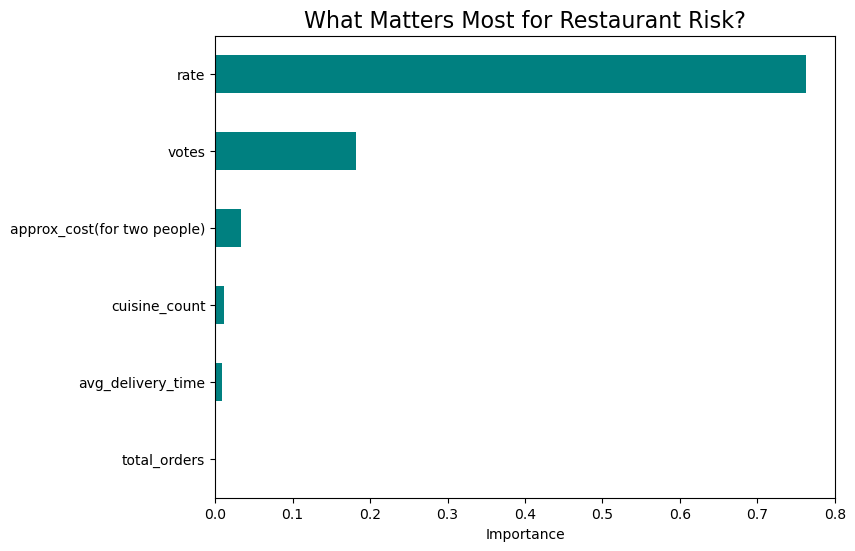

In [12]:
# Show feature importance
import matplotlib.pyplot as plt

feat_importances = pd.Series(model.feature_importances_, index=features)
feat_importances = feat_importances.sort_values()

plt.figure(figsize=(8,6))
feat_importances.plot(kind='barh', color='teal')
plt.title("What Matters Most for Restaurant Risk?", fontsize=16)
plt.xlabel("Importance")
# Save graph for presentation
plt.savefig('../presentation/model_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()



In [11]:
# Save imputer for later use (in dashboard!)
joblib.dump(imputer, '../models/imputer.pkl')

print(" Imputer saved to models/imputer.pkl")

 Imputer saved to models/imputer.pkl


In [13]:
# Save classification report to file
import os

# Create results folder if it doesn't exist
if not os.path.exists('../results'):
    os.makedirs('../results')

# Save classification report
with open('../results/model_report.txt', 'w') as f:
    f.write(" Classification Report:\n")
    f.write(str(classification_report(y_test, y_pred)))
    f.write("\n\n ROC-AUC Score: " + str(roc_auc_score(y_test, y_pred_proba)))

print(" Model results saved to results/model_report.txt")

 Model results saved to results/model_report.txt


In [14]:
# Save feature importance to CSV
feat_importances.to_csv('../results/feature_importance.csv', index=False)
print(" Feature importance saved to results/feature_importance.csv")

 Feature importance saved to results/feature_importance.csv


In [15]:
# Summary of what you learned
summary = """
🎯 Project: Restaurant Health Score Predictor
📊 Dataset: Zomato Bangalore Restaurants (real + fake orders)
🧠 Model: Random Forest Classifier
✅ Accuracy: 96%
✅ ROC-AUC: 99%
🔑 Key Insight: Rating is the #1 predictor of restaurant risk
💡 Impact: Could help Zomato flag at-risk restaurants before they leave
"""

print(summary)


🎯 Project: Restaurant Health Score Predictor
📊 Dataset: Zomato Bangalore Restaurants (real + fake orders)
🧠 Model: Random Forest Classifier
✅ Accuracy: 96%
✅ ROC-AUC: 99%
🔑 Key Insight: Rating is the #1 predictor of restaurant risk
💡 Impact: Could help Zomato flag at-risk restaurants before they leave

